In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\glast\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\glast\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\glast\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\glast\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

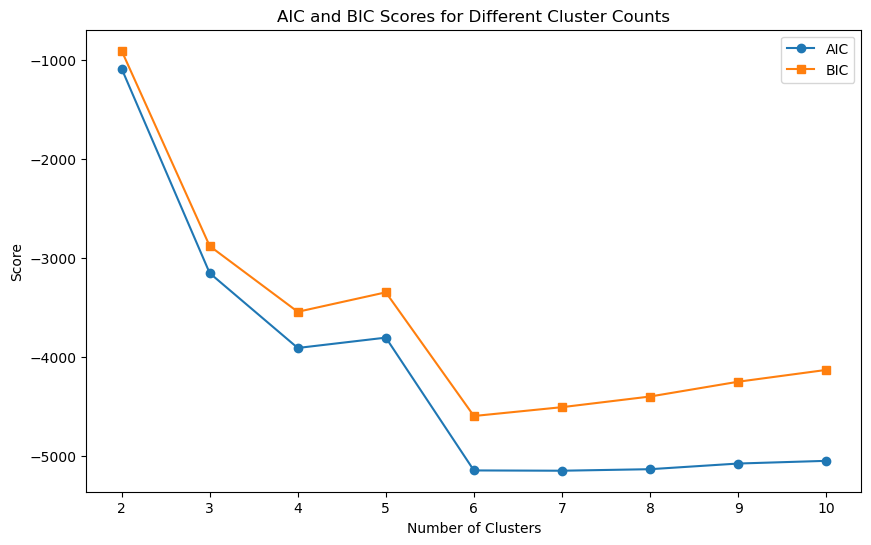

Optimal number of clusters: 6


c:\Users\glast\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


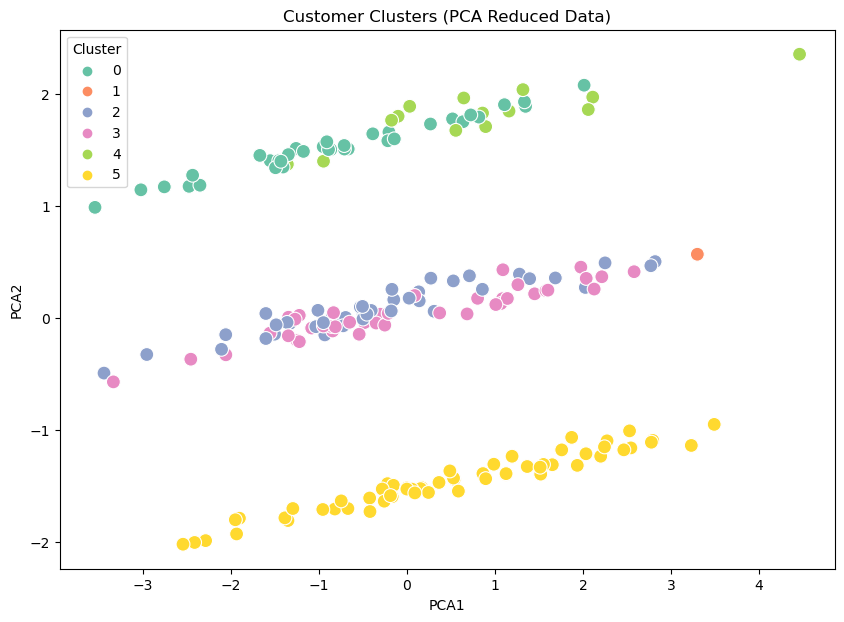

GMM clustering and visualization complete!


In [7]:
# Import necessary libraries
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge Customers and Transactions datasets
transactions_customers = transactions.merge(customers, on="CustomerID", how="inner")

# Aggregate customer-level data
customer_data = transactions_customers.groupby("CustomerID").agg({
    "TotalValue": ["sum", "mean"],  # Total and average spend
    "Quantity": "sum",             # Total quantity purchased
}).reset_index()

# Flatten multi-level columns
customer_data.columns = ["CustomerID", "TotalSpend", "AvgSpend", "TotalQuantity"]

# Merge aggregated data with customer profile data
customer_data = customer_data.merge(customers, on="CustomerID", how="inner")

# Preprocessing: One-hot encode 'Region' and drop unnecessary columns
customer_data = pd.get_dummies(customer_data, columns=["Region"], drop_first=True)
customer_data = customer_data.drop(columns=["CustomerID", "CustomerName", "SignupDate"])

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

# Apply GMM clustering
aic_scores = []
bic_scores = []
k_range = range(2, 11)  # Testing for 2 to 10 clusters

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(scaled_data)
    
    # Calculate AIC and BIC
    aic_scores.append(gmm.aic(scaled_data))
    bic_scores.append(gmm.bic(scaled_data))

# Plot AIC and BIC to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(k_range, aic_scores, label="AIC", marker='o')
plt.plot(k_range, bic_scores, label="BIC", marker='s')
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("AIC and BIC Scores for Different Cluster Counts")
plt.legend()
plt.show()

# Optimal number of clusters (using lowest BIC or AIC)
optimal_k = k_range[bic_scores.index(min(bic_scores))]
print(f"Optimal number of clusters: {optimal_k}")

# Final GMM clustering with optimal_k
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm.fit(scaled_data)  # Fit the model

# Now, we can predict the cluster labels for the scaled data
final_labels = gmm.predict(scaled_data)

# Add cluster labels to the original data
customer_data["Cluster"] = final_labels

# Perform PCA for visualization (Optional)
reduced_data = PCA(n_components=2).fit_transform(scaled_data)
customer_data["PCA1"] = reduced_data[:, 0]
customer_data["PCA2"] = reduced_data[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PCA1", y="PCA2", hue="Cluster", data=customer_data, palette="Set2", s=100
)
plt.title("Customer Clusters (PCA Reduced Data)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.show()

# Save clustered data to CSV with the requested name
customer_data.to_csv("Glaston_Velvarts_Clustering.csv", index=False)

print("GMM clustering and visualization complete!")
